In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


# CHEST XRAY PROJECT

### Importing Relevant Libraries/Packages

In [2]:
import cv2
import os
import shutil
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras

# Keras Sequential Model
from tensorflow.keras.models import Sequential

# Importing all the different layers, callbacks and optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

###  Setting the paths to train, test, and validation directories

In [3]:
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"
val_dir = "/content/drive/MyDrive/chest_xray/val"

### Defining image size and batch size

In [4]:
image_size = (256, 256)
batch_size = 32

### Data Augmentation and Normalization for Training

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

### Loading and augmenting training data

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'  # Set color_mode to 'grayscale'
)

Found 4202 images belonging to 2 classes.


### Normalization for validation

In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)

### Loading and normalizing validation data

In [8]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'  # Set color_mode to 'grayscale'
)

Found 1049 images belonging to 2 classes.


### Normalization for testing

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

### Loading and normalizing test data

In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='grayscale'  # Set color_mode to 'grayscale'
)

Found 624 images belonging to 2 classes.


### Data Visualisation

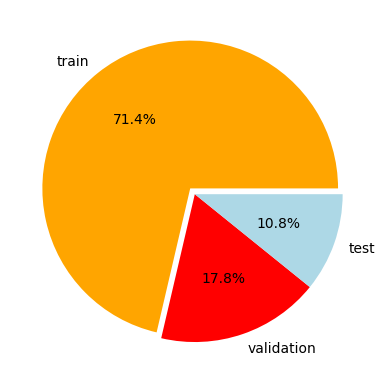

In [11]:
plt.pie([len(train_generator), len(val_generator), len(test_generator)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['orange', 'red', 'lightblue'], explode=(0.05, 0, 0))
plt.show()

### Printing the number of samples in each class

In [12]:
# Print the mapping of class names to class indices
print("Class indices:", train_generator.class_indices)

# Count the number of samples in each class for the training set
class_counts_train = {class_name: 0 for class_name in train_generator.class_indices}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        class_count = len(os.listdir(class_dir))
        class_counts_train[class_name] = class_count

# Print the class counts for the training set
print("Training class counts:", class_counts_train)

# Count the number of samples in each class for the validation set
class_counts_val = {class_name: 0 for class_name in val_generator.class_indices}
for class_name in os.listdir(val_dir):
    class_dir = os.path.join(val_dir, class_name)
    if os.path.isdir(class_dir):
        class_count = len(os.listdir(class_dir))
        class_counts_val[class_name] = class_count

# Print the class counts for the validation set
print("Validation class counts:", class_counts_val)

# Count the number of samples in each class for the test set
class_counts_test = {class_name: 0 for class_name in test_generator.class_indices}
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        class_count = len(os.listdir(class_dir))
        class_counts_test[class_name] = class_count

# Print the class counts for the test set
print("Test class counts:", class_counts_test)

Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Training class counts: {'NORMAL': 1082, 'PNEUMONIA': 3120}
Validation class counts: {'NORMAL': 267, 'PNEUMONIA': 782}
Test class counts: {'NORMAL': 234, 'PNEUMONIA': 390}


### Displaying training data samples

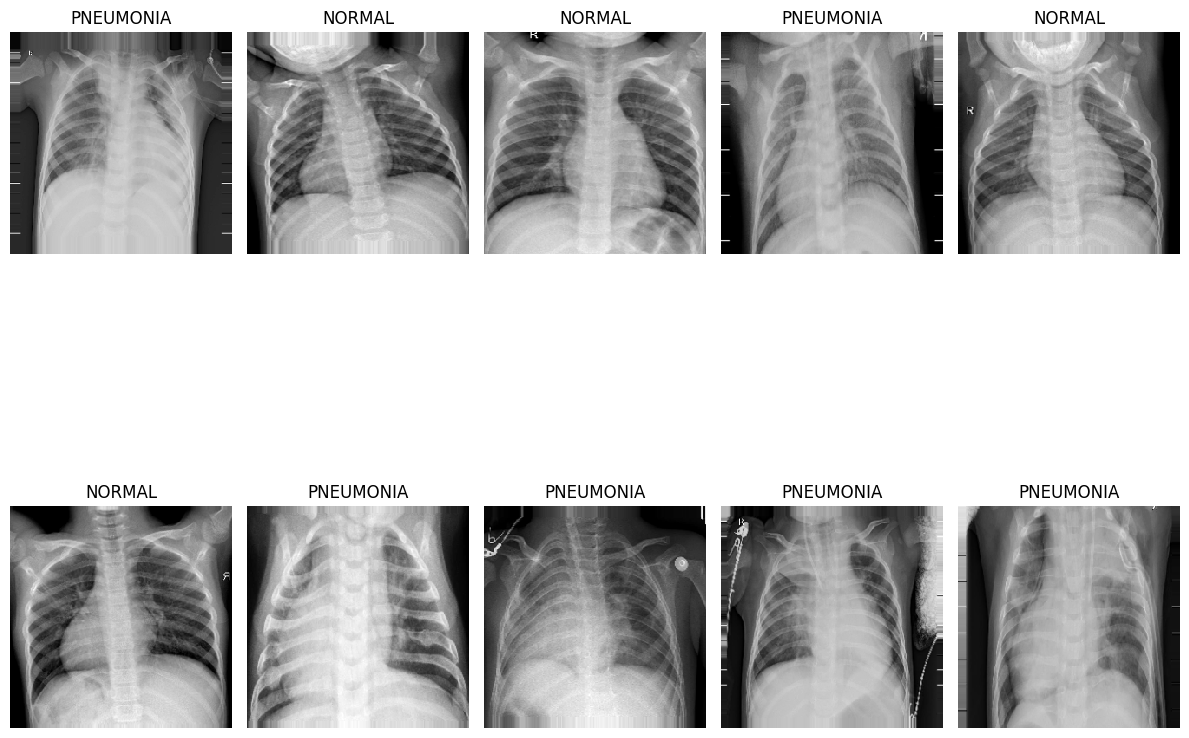

In [13]:
plt.figure(figsize=(12, 12))

for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break

plt.tight_layout()
plt.show()

## Baseline Model Architecture

In [14]:
# Building the CNN model with 3 convolution blocks
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# Fully Connected Layers
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
# Output Layer
model.add(Dense(1, activation = 'sigmoid'))

### Model Summary

In [15]:
# print the summary of the model constructed
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

### Defining Model Checkpoints

In [16]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray.hdf5"), save_best_only=True)

### Compiling the Model

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model Training

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt]
)

Epoch 1/10
131/131 [==============================] - 1071s 8s/step - loss: 0.3070 - accuracy: 0.8659 - val_loss: 0.2183 - val_accuracy: 0.9180
Epoch 2/10
131/131 [==============================] - 76s 577ms/step - loss: 0.2146 - accuracy: 0.9144 - val_loss: 0.1820 - val_accuracy: 0.9365
Epoch 3/10
131/131 [==============================] - 70s 535ms/step - loss: 0.1792 - accuracy: 0.9321 - val_loss: 0.1932 - val_accuracy: 0.9434
Epoch 4/10
131/131 [==============================] - 70s 532ms/step - loss: 0.1563 - accuracy: 0.9391 - val_loss: 0.2399 - val_accuracy: 0.9131
Epoch 5/10
131/131 [==============================] - 76s 577ms/step - loss: 0.1562 - accuracy: 0.9410 - val_loss: 0.1692 - val_accuracy: 0.9346
Epoch 6/10
131/131 [==============================] - 71s 539ms/step - loss: 0.1590 - accuracy: 0.9396 - val_loss: 0.1775 - val_accuracy: 0.9346
Epoch 7/10
131/131 [==============================] - 76s 578ms/step - loss: 0.1475 - accuracy: 0.9453 - val_loss: 0.1328 - val_acc

### Visualising the metrics

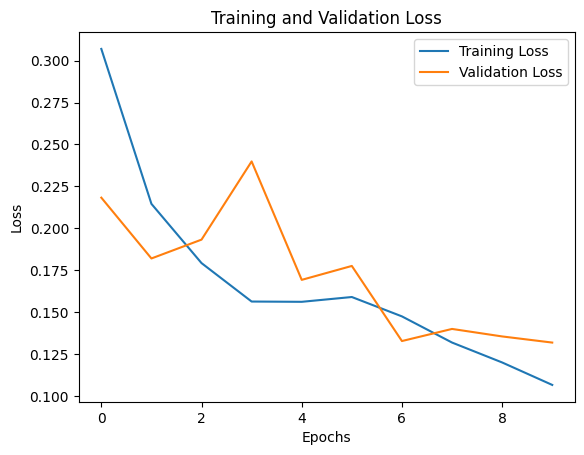

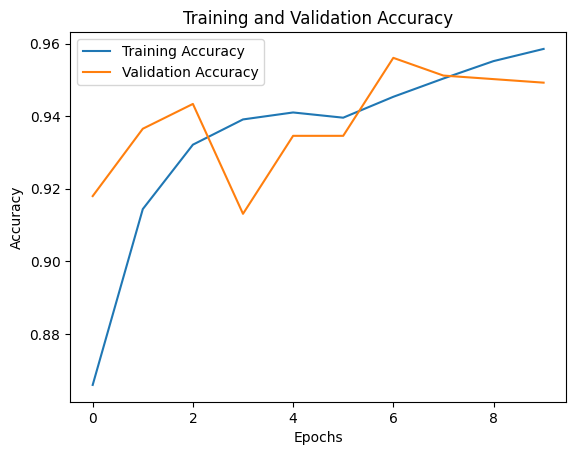

In [20]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

### Evaluating the Model on the test set

In [21]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 250s 14s/step - loss: 0.4437 - accuracy: 0.8618
Test loss: 0.4436691105365753
Test accuracy: 0.8618420958518982


### Making Predictions

In [22]:
predictions = model.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 5s 221ms/step


### Confusion Matrix

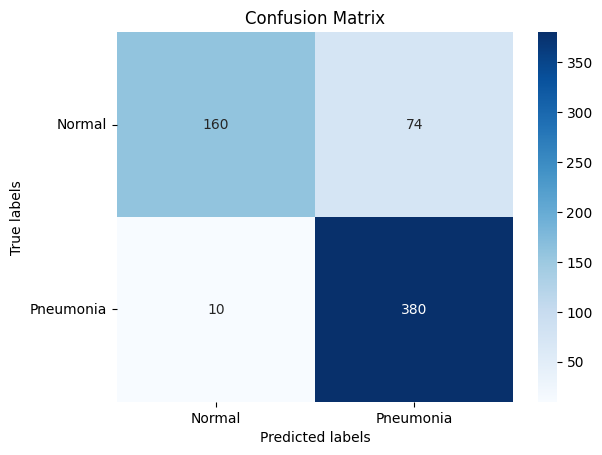

In [23]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [24]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.68      0.79       234
   PNEUMONIA       0.84      0.97      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



## Model 1 Architecture: 3 convolution blocks + 256 Neurons + 0.5 dropout + early stopping patience of 3

In [25]:
# Building the CNN model with 3 convolution blocks and 0.5 Dropout
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))
# Fully Connected Layers
model1.add(Flatten())
model1.add(Dense(256, activation = 'relu'))
model1.add(Dropout(0.5)) # Adding a dropout of 0.5
# Output Layer
model1.add(Dense(1, activation = 'sigmoid'))

In [26]:
# printing the summary of the model constructed
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

### Defining model checkpoint and early stopping

In [27]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray.hdf5"), save_best_only=True)
es = EarlyStopping(patience = 3)

### Compiling the model

In [28]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the model

In [29]:
history1 = model1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - 83s 607ms/step - loss: 0.4290 - accuracy: 0.8305 - val_loss: 0.1934 - val_accuracy: 0.9209
Epoch 2/10
131/131 [==============================] - 79s 607ms/step - loss: 0.2469 - accuracy: 0.9007 - val_loss: 0.1795 - val_accuracy: 0.9268
Epoch 3/10
131/131 [==============================] - 80s 614ms/step - loss: 0.2346 - accuracy: 0.9005 - val_loss: 0.1722 - val_accuracy: 0.9336
Epoch 4/10
131/131 [==============================] - 72s 549ms/step - loss: 0.2111 - accuracy: 0.9129 - val_loss: 0.2105 - val_accuracy: 0.9287
Epoch 5/10
131/131 [==============================] - 73s 560ms/step - loss: 0.2119 - accuracy: 0.9182 - val_loss: 0.1563 - val_accuracy: 0.9395
Epoch 6/10
131/131 [==============================] - 76s 580ms/step - loss: 0.1848 - accuracy: 0.9269 - val_loss: 0.1438 - val_accuracy: 0.9443
Epoch 7/10
131/131 [==============================] - 81s 621ms/step - loss: 0.1698 - accuracy: 0.9317 - val_loss: 0.1622 - val_ac

### Visualising the metrics

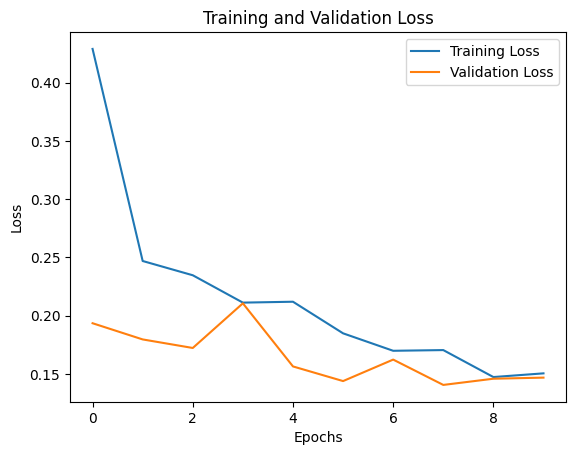

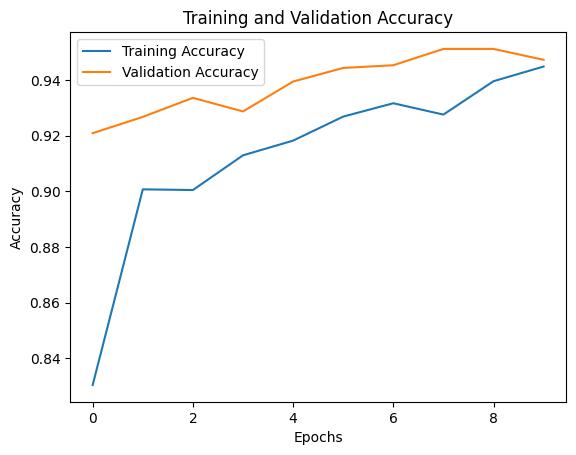

In [30]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

### Evaluating the model on the test set

In [31]:
test_loss, test_acc = model1.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 10s 530ms/step - loss: 0.3734 - accuracy: 0.8766
Test loss: 0.3733662962913513
Test accuracy: 0.8766447305679321


### Making Predictions

In [32]:
predictions = model1.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 5s 229ms/step


### Confusion Matrix

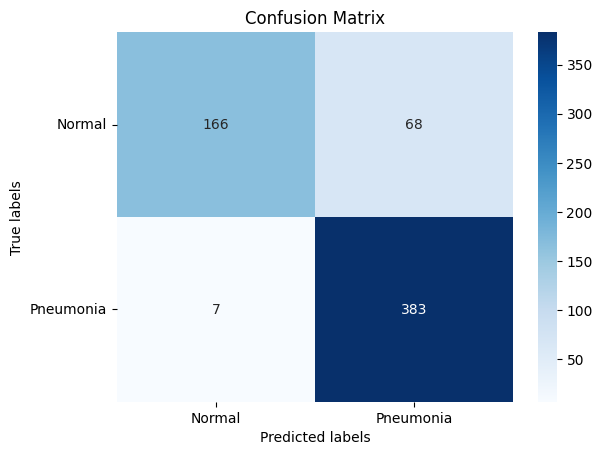

In [33]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification report

In [34]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.96      0.71      0.82       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.86       624
weighted avg       0.89      0.88      0.88       624



## Model 2: Pre-trained MobileNet Model + 0.5 Dropout + 512 Neurons

In [52]:
from tensorflow.keras.applications import MobileNet

### Loading the pre-trained MobileNet model (excluding the top classification layer)

In [55]:
# Defining the input shape for MobileNet (RGB images)
input_shape = (image_size[0], image_size[1], 3)

# Loading the MobileNet base model without the top classification layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

### Freezing the pre-trained layers

In [56]:
for layer in base_model.layers:
    layer.trainable = False

### Building the model architecture by adding classification layers

In [57]:
model2 = Sequential()
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(512, activation = 'relu'))
model2.add(Dropout(0.5)) # Adding a dropout of 0.5
model2.add(Dense(1, activation = 'sigmoid'))

### Compiling the model

In [58]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Data Preprocessing

In [59]:
# Modify the data preprocessing for train_generator, val_generator, and test_generator
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen2 = ImageDataGenerator(
    rescale=1./255
)

test_datagen2 = ImageDataGenerator(
    rescale=1./255
)

In [60]:
image_size = (256, 256)
batch_size = 32

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

val_generator2 = val_datagen2.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

test_generator2 = test_datagen2.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

Found 4202 images belonging to 2 classes.
Found 1049 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Training the model

In [61]:
history2 = model2.fit(
    train_generator2,
    steps_per_epoch=train_generator2.samples // batch_size,
    epochs=10,
    validation_data=val_generator2,
    validation_steps=val_generator2.samples // batch_size,
)

Epoch 1/10
131/131 [==============================] - 138s 1s/step - loss: 2.3877 - accuracy: 0.9129 - val_loss: 0.0786 - val_accuracy: 0.9688
Epoch 2/10
131/131 [==============================] - 128s 975ms/step - loss: 0.1385 - accuracy: 0.9470 - val_loss: 0.0775 - val_accuracy: 0.9688
Epoch 3/10
131/131 [==============================] - 130s 994ms/step - loss: 0.1088 - accuracy: 0.9628 - val_loss: 0.0808 - val_accuracy: 0.9727
Epoch 4/10
131/131 [==============================] - 134s 1s/step - loss: 0.1107 - accuracy: 0.9583 - val_loss: 0.0832 - val_accuracy: 0.9678
Epoch 5/10
131/131 [==============================] - 134s 1s/step - loss: 0.1239 - accuracy: 0.9530 - val_loss: 0.0936 - val_accuracy: 0.9619
Epoch 6/10
131/131 [==============================] - 127s 967ms/step - loss: 0.1065 - accuracy: 0.9626 - val_loss: 0.0717 - val_accuracy: 0.9746
Epoch 7/10
131/131 [==============================] - 128s 975ms/step - loss: 0.0884 - accuracy: 0.9690 - val_loss: 0.0780 - val_accu

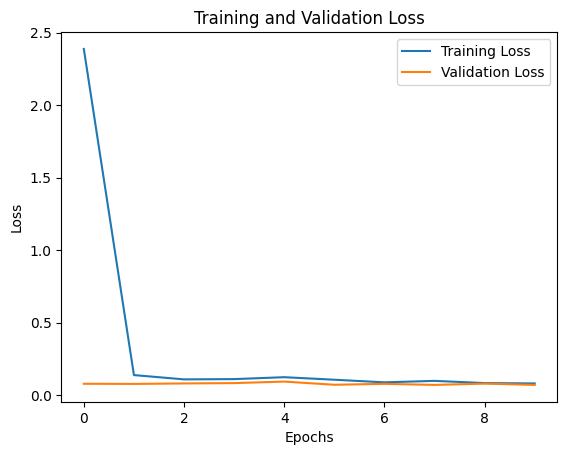

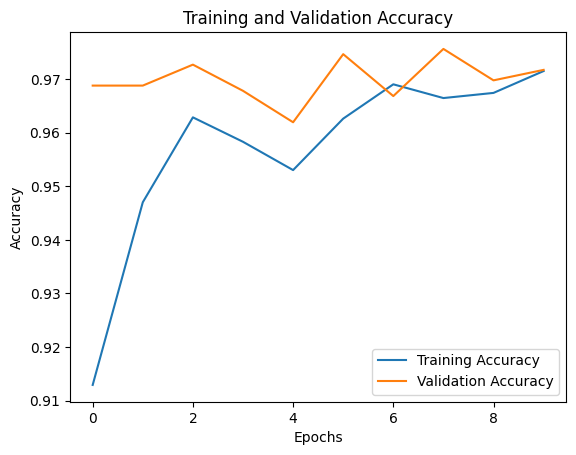

In [62]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()


# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

### Evaluating the model on the test set

In [63]:
test_loss, test_acc = model2.evaluate(test_generator2, steps=test_generator2.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 7s 315ms/step - loss: 0.3970 - accuracy: 0.8947
Test loss: 0.3969951272010803
Test accuracy: 0.8947368264198303


### Making Predictions

In [65]:
predictions = model2.predict(test_generator2)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 7s 316ms/step


### Confusion Matrix

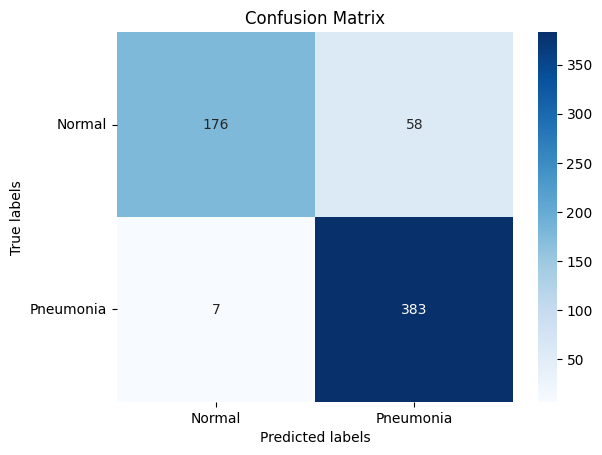

In [66]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator2.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [67]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.96      0.75      0.84       234
   PNEUMONIA       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



## Model 3: Pre-trained VGG16 Model + 0.5 Dropout + 512 Neurons

In [68]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

### Data Preprocessing with VGG16

In [69]:
train_datagen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen3 = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen3 = ImageDataGenerator(preprocessing_function=preprocess_input)

In [70]:
image_size = (256, 256)
batch_size = 32

train_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    #color_mode='grayscale'  # Set color_mode to 'grayscale'
)

val_generator3 = val_datagen3.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    #color_mode='grayscale'  # Set color_mode to 'grayscale'
)

test_generator3 = test_datagen3.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    #color_mode='grayscale'  # Set color_mode to 'grayscale'
)

Found 4202 images belonging to 2 classes.
Found 1049 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [71]:
# Defining the input shape for MobileNet (RGB images)
input_shape = (image_size[0], image_size[1], 3)

# Loading the MobileNet base model without the top classification layer
base_model2 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 3s 0us/step


In [72]:
# Freezing the layers
for layer in base_model2.layers:
    layer.trainable = False

In [73]:
# Model Architecture
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())
model3.add(Dense(512, activation = 'relu'))
model3.add(Dropout(0.5)) # Adding a dropout of 0.5
model3.add(Dense(1, activation = 'sigmoid'))

In [76]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model3.hdf5"), save_best_only=True)
es = EarlyStopping(patience = 3)

In [77]:
# Compiling the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [78]:
# Training the model
history3 = model3.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // batch_size,
    epochs=10,
    validation_data=val_generator3,
    validation_steps=val_generator3.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - 83s 626ms/step - loss: 0.3995 - accuracy: 0.9540 - val_loss: 0.0769 - val_accuracy: 0.9775
Epoch 2/10
131/131 [==============================] - 78s 597ms/step - loss: 0.1123 - accuracy: 0.9657 - val_loss: 0.0600 - val_accuracy: 0.9814
Epoch 3/10
131/131 [==============================] - 74s 566ms/step - loss: 0.0871 - accuracy: 0.9755 - val_loss: 0.0429 - val_accuracy: 0.9844
Epoch 4/10
131/131 [==============================] - 80s 613ms/step - loss: 0.0596 - accuracy: 0.9763 - val_loss: 0.0495 - val_accuracy: 0.9824
Epoch 5/10
131/131 [==============================] - 76s 579ms/step - loss: 0.0517 - accuracy: 0.9844 - val_loss: 0.0652 - val_accuracy: 0.9863
Epoch 6/10
131/131 [==============================] - 85s 653ms/step - loss: 0.0394 - accuracy: 0.9878 - val_loss: 0.0420 - val_accuracy: 0.9893
Epoch 7/10
131/131 [==============================] - 73s 556ms/step - loss: 0.0371 - accuracy: 0.9866 - val_loss: 0.0506 - val_ac

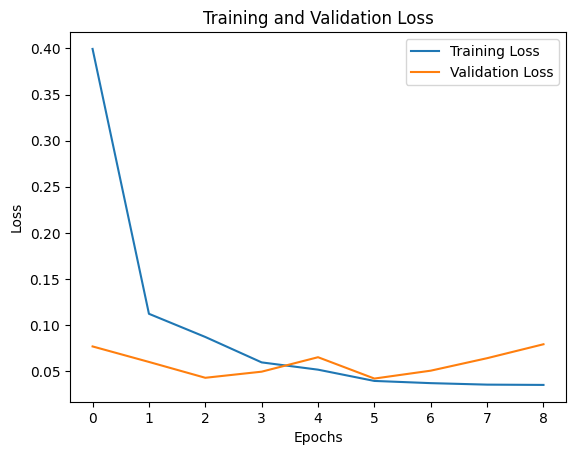

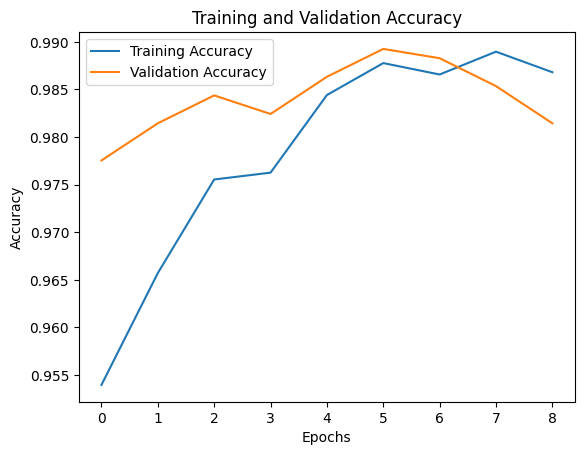

In [79]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()


# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [80]:
test_loss, test_acc = model3.evaluate(test_generator3, steps=test_generator3.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 8s 386ms/step - loss: 1.1699 - accuracy: 0.8553
Test loss: 1.1698572635650635
Test accuracy: 0.8552631735801697


### Making Predictions

In [81]:
predictions = model3.predict(test_generator3)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 11s 551ms/step


### Confusion Matrix

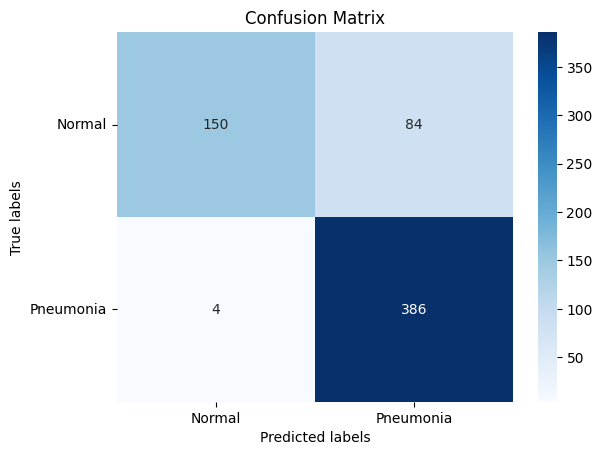

In [82]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator3.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [83]:
print(classification_report(y_true=test_generator3.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.64      0.77       234
   PNEUMONIA       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



## Model 4: Pre-trained VGG16 Model + 0.5 Dropout + 1024 Neurons

In [84]:
# Model Architecture
model4 = Sequential()
model4.add(base_model2)
model4.add(Flatten())
model4.add(Dense(1024, activation = 'relu'))
model4.add(Dropout(0.5)) # Adding a dropout of 0.5
model4.add(Dense(1, activation = 'sigmoid'))

In [85]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model4.hdf5"), save_best_only=True)
es = EarlyStopping(patience = 3)

In [86]:
# Compile the model
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [87]:
# Training the model
history4 = model4.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // batch_size,
    epochs=10,
    validation_data=val_generator3,
    validation_steps=val_generator3.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - 84s 619ms/step - loss: 4.7624 - accuracy: 0.9432 - val_loss: 0.3088 - val_accuracy: 0.9707
Epoch 2/10
131/131 [==============================] - 75s 571ms/step - loss: 0.1711 - accuracy: 0.9796 - val_loss: 0.1445 - val_accuracy: 0.9766
Epoch 3/10
131/131 [==============================] - 75s 570ms/step - loss: 0.0704 - accuracy: 0.9863 - val_loss: 0.0555 - val_accuracy: 0.9863
Epoch 4/10
131/131 [==============================] - 75s 572ms/step - loss: 0.0387 - accuracy: 0.9897 - val_loss: 0.0744 - val_accuracy: 0.9834
Epoch 5/10
131/131 [==============================] - 85s 647ms/step - loss: 0.0249 - accuracy: 0.9935 - val_loss: 0.0469 - val_accuracy: 0.9873
Epoch 6/10
131/131 [==============================] - 75s 575ms/step - loss: 0.0220 - accuracy: 0.9928 - val_loss: 0.0559 - val_accuracy: 0.9873
Epoch 7/10
131/131 [==============================] - 76s 580ms/step - loss: 0.0377 - accuracy: 0.9914 - val_loss: 0.0845 - val_ac

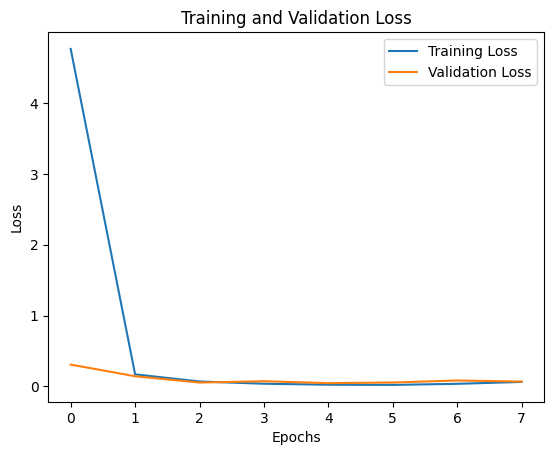

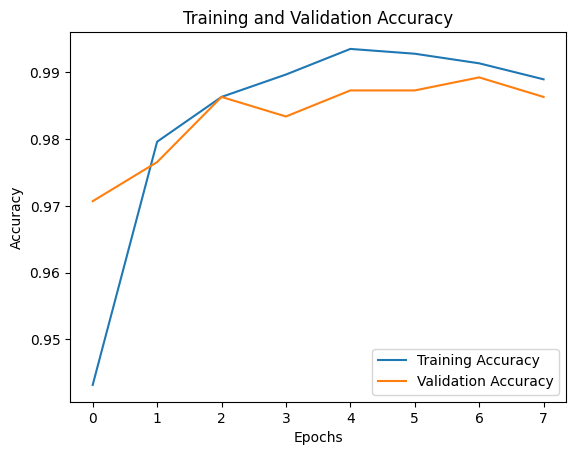

In [88]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [89]:
test_loss, test_acc = model4.evaluate(test_generator3, steps=test_generator3.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 7s 321ms/step - loss: 2.9273 - accuracy: 0.8224
Test loss: 2.927311897277832
Test accuracy: 0.8223684430122375


### Making Predictions

In [90]:
predictions = model4.predict(test_generator3)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 7s 324ms/step


### Confusion Matrix

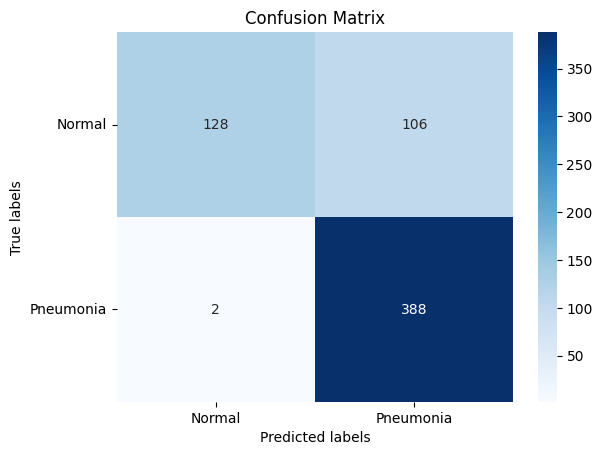

In [91]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator3.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [92]:
print(classification_report(y_true=test_generator3.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.55      0.70       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.77      0.79       624
weighted avg       0.86      0.83      0.81       624



## Model 5: 4 convolution blocks + 512 Neurons + 0.5 dropout

In [93]:
# Building the CNN model with 4 convolution blocks
model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Flatten())
model5.add(Dense(512, activation = 'relu'))
model5.add(Dropout(0.5)) # Adding a dropout of 0.5
model5.add(Dense(1, activation = 'sigmoid'))

In [94]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model5.hdf5"), save_best_only=True)
es = EarlyStopping(patience = 3)

In [95]:
# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
# Training the model
history5 = model5.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - 70s 495ms/step - loss: 0.3915 - accuracy: 0.8365 - val_loss: 0.2171 - val_accuracy: 0.9199
Epoch 2/10
131/131 [==============================] - 65s 500ms/step - loss: 0.2372 - accuracy: 0.9019 - val_loss: 0.2252 - val_accuracy: 0.9150
Epoch 3/10
131/131 [==============================] - 71s 540ms/step - loss: 0.2020 - accuracy: 0.9175 - val_loss: 0.1681 - val_accuracy: 0.9404
Epoch 4/10
131/131 [==============================] - 65s 495ms/step - loss: 0.1738 - accuracy: 0.9295 - val_loss: 0.1859 - val_accuracy: 0.9258
Epoch 5/10
131/131 [==============================] - 68s 519ms/step - loss: 0.1640 - accuracy: 0.9355 - val_loss: 0.1688 - val_accuracy: 0.9365
Epoch 6/10
131/131 [==============================] - 65s 500ms/step - loss: 0.1674 - accuracy: 0.9374 - val_loss: 0.1616 - val_accuracy: 0.9443
Epoch 7/10
131/131 [==============================] - 68s 520ms/step - loss: 0.1463 - accuracy: 0.9422 - val_loss: 0.1469 - val_ac

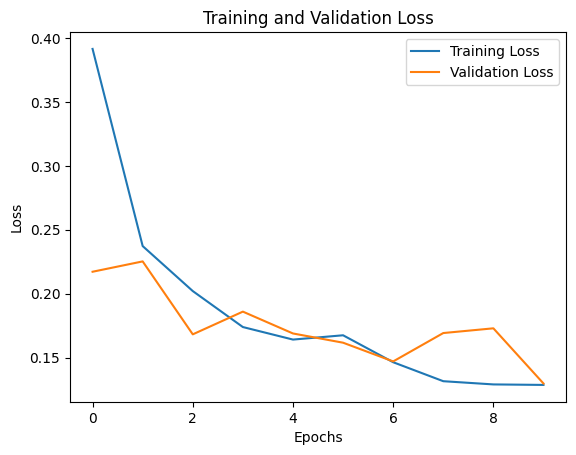

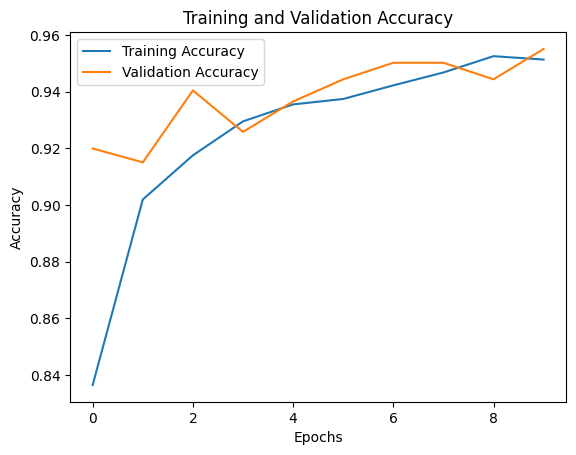

In [97]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history5.history['loss'], label='Training Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history5.history['accuracy'], label='Training Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [98]:
test_loss, test_acc = model5.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 4s 224ms/step - loss: 0.3902 - accuracy: 0.8914
Test loss: 0.3901737928390503
Test accuracy: 0.8914473652839661


In [99]:
predictions = model5.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 4s 182ms/step


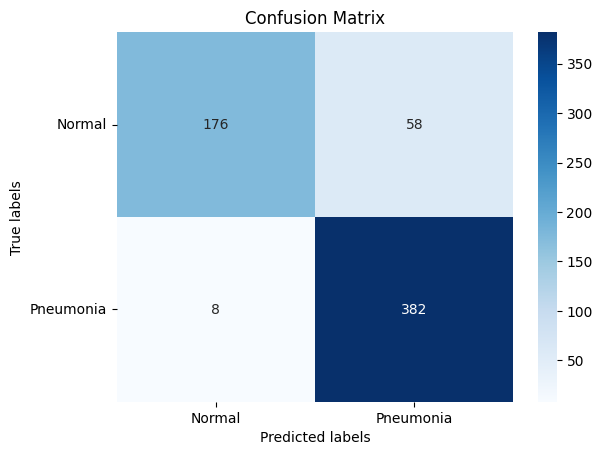

In [100]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

In [101]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.96      0.75      0.84       234
   PNEUMONIA       0.87      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



## Model 6: 4 Convolution Blocks + 512 Neurons + 0.25 Dropout

In [102]:
# Building the CNN model with 4 convolution blocks
model6 = Sequential()
model6.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Flatten())
model6.add(Dense(512, activation = 'relu'))
model6.add(Dropout(0.25)) # Adding a dropout of 0.25
model6.add(Dense(1, activation = 'sigmoid'))

In [103]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model6.hdf5"), save_best_only=True)
es = EarlyStopping(patience = 3, verbose = 1)

In [104]:
# Compile the model
model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [105]:
# Training the model
history6 = model6.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - 69s 509ms/step - loss: 0.3825 - accuracy: 0.8331 - val_loss: 0.2433 - val_accuracy: 0.9189
Epoch 2/10
131/131 [==============================] - 71s 538ms/step - loss: 0.2342 - accuracy: 0.9055 - val_loss: 0.2050 - val_accuracy: 0.9336
Epoch 3/10
131/131 [==============================] - 68s 517ms/step - loss: 0.2090 - accuracy: 0.9153 - val_loss: 0.1860 - val_accuracy: 0.9375
Epoch 4/10
131/131 [==============================] - 66s 504ms/step - loss: 0.1811 - accuracy: 0.9271 - val_loss: 0.1738 - val_accuracy: 0.9307
Epoch 5/10
131/131 [==============================] - 68s 522ms/step - loss: 0.1612 - accuracy: 0.9374 - val_loss: 0.1680 - val_accuracy: 0.9463
Epoch 6/10
131/131 [==============================] - 66s 506ms/step - loss: 0.1469 - accuracy: 0.9448 - val_loss: 0.1468 - val_accuracy: 0.9453
Epoch 7/10
131/131 [==============================] - 66s 503ms/step - loss: 0.1462 - accuracy: 0.9451 - val_loss: 0.1640 - val_ac

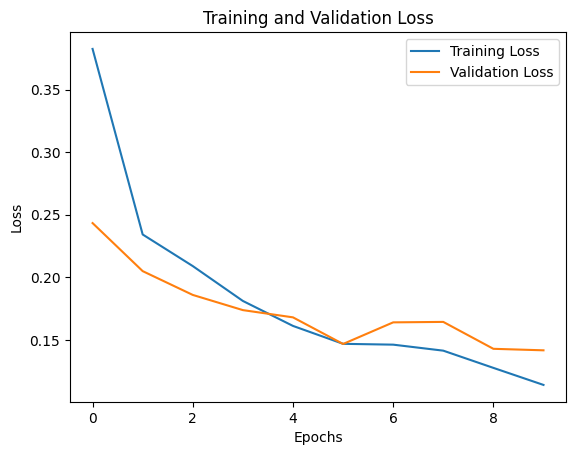

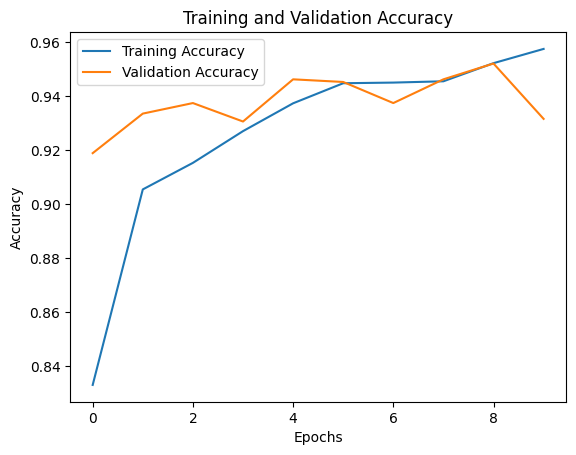

In [106]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history6.history['accuracy'], label='Training Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [107]:
test_loss, test_acc = model6.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 5s 248ms/step - loss: 0.2809 - accuracy: 0.9145
Test loss: 0.2809315323829651
Test accuracy: 0.9144737124443054


### Making Predictions

In [108]:
predictions = model6.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 4s 181ms/step


### Confusion Matrix

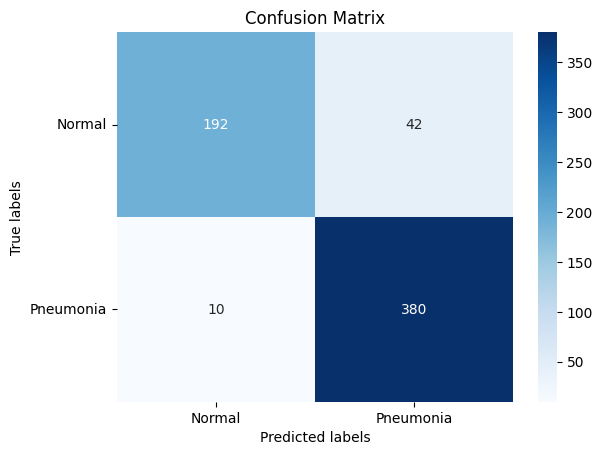

In [109]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [110]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.82      0.88       234
   PNEUMONIA       0.90      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



## Model 7: 3 Convolution Blocks + 256 Neurons + L2 Regularizer + 0.5 Dropout

In [111]:
from tensorflow.keras.regularizers import l2, l1

In [112]:
# Building the CNN model with 3 convolution blocks
model7 = Sequential()
model7.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Flatten())
model7.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
model7.add(Dropout(0.5)) # Adding a dropout of 0.5
model7.add(Dense(1, activation = 'sigmoid'))

In [113]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model7.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3, verbose = 1)

In [114]:
# Compile the model
model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [115]:
# Training the model
history7 = model7.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.9109 - accuracy: 0.7592
Epoch 1: val_loss improved from inf to 0.73788, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model7.hdf5
131/131 [==============================] - 72s 529ms/step - loss: 0.9109 - accuracy: 0.7592 - val_loss: 0.7379 - val_accuracy: 0.7842
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.8547
Epoch 2: val_loss improved from 0.73788 to 0.36640, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model7.hdf5
131/131 [==============================] - 74s 562ms/step - loss: 0.5081 - accuracy: 0.8547 - val_loss: 0.3664 - val_accuracy: 0.9180
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.4109 - accuracy: 0.8693
Epoch 3: val_loss improved from 0.36640 to 0.35678, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model7.hdf5
131/131 [==============================] - 74s 565ms

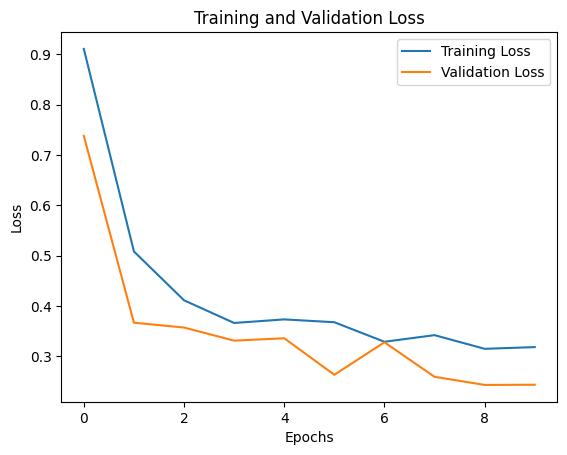

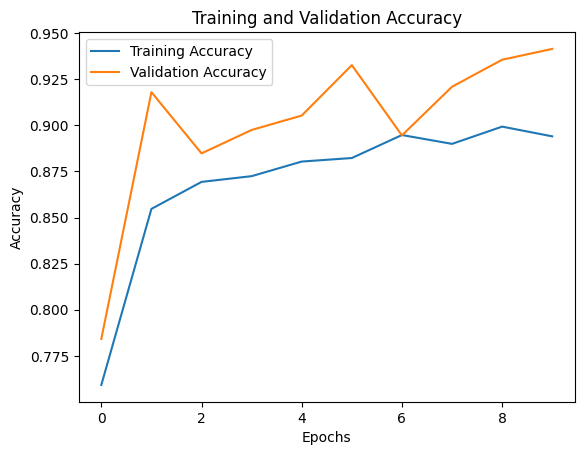

In [116]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history7.history['loss'], label='Training Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history7.history['accuracy'], label='Training Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [117]:
test_loss, test_acc = model7.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 4s 184ms/step - loss: 0.5262 - accuracy: 0.7829
Test loss: 0.526242733001709
Test accuracy: 0.7828947305679321


### Making Predictions

In [118]:
predictions = model7.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 4s 177ms/step


### Confusion Matrix

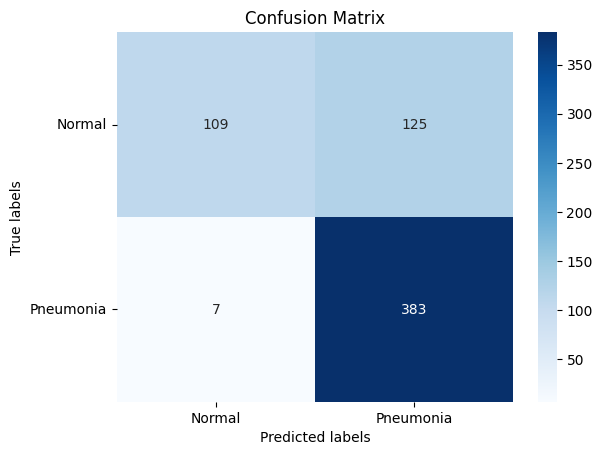

In [119]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [120]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.94      0.47      0.62       234
   PNEUMONIA       0.75      0.98      0.85       390

    accuracy                           0.79       624
   macro avg       0.85      0.72      0.74       624
weighted avg       0.82      0.79      0.77       624



## Model 8: 3 Convolution Blocks + 256 neurons + L2 + 0.5 Dropout + 5 Epochs

In [121]:
# Building the CNN model with 3 convolution blocks
model8 = Sequential()
model8.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Flatten())
model8.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
model8.add(Dropout(0.5)) # Adding a dropout of 0.5
model8.add(Dense(1, activation = 'sigmoid'))

In [122]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model8.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3, verbose = 1)

In [123]:
# Compile the model
model8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [124]:
# Training the model
history8 = model8.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/5
131/131 [==============================] - ETA: 0s - loss: 0.8730 - accuracy: 0.7882
Epoch 1: val_loss improved from inf to 0.43929, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model8.hdf5
131/131 [==============================] - 71s 523ms/step - loss: 0.8730 - accuracy: 0.7882 - val_loss: 0.4393 - val_accuracy: 0.9072
Epoch 2/5
131/131 [==============================] - ETA: 0s - loss: 0.4555 - accuracy: 0.8715
Epoch 2: val_loss improved from 0.43929 to 0.31620, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model8.hdf5
131/131 [==============================] - 72s 549ms/step - loss: 0.4555 - accuracy: 0.8715 - val_loss: 0.3162 - val_accuracy: 0.9307
Epoch 3/5
131/131 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8827
Epoch 3: val_loss did not improve from 0.31620
131/131 [==============================] - 67s 514ms/step - loss: 0.4010 - accuracy: 0.8827 - val_loss: 0.3450 - val_accuracy: 0.9131
Epoch 

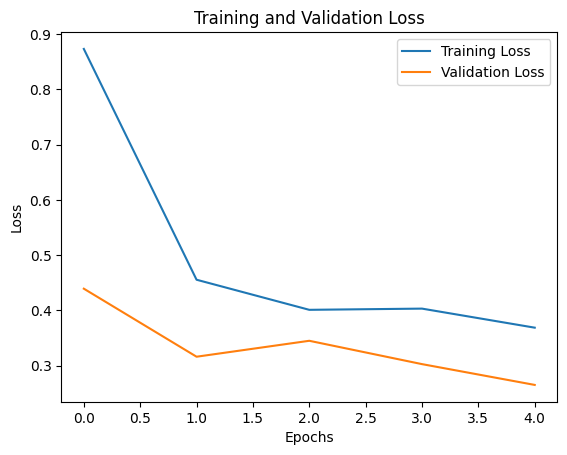

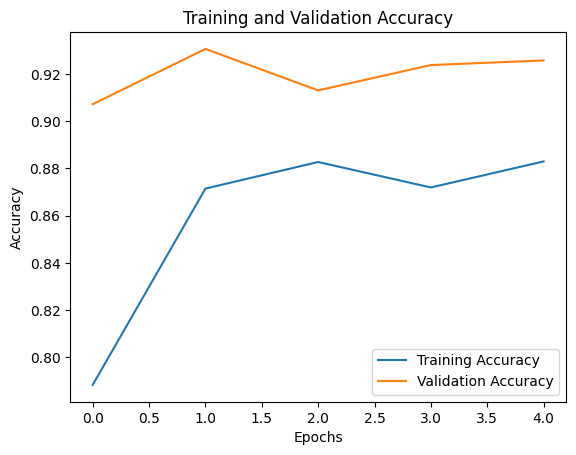

In [125]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history8.history['loss'], label='Training Loss')
plt.plot(history8.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history8.history['accuracy'], label='Training Accuracy')
plt.plot(history8.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [126]:
test_loss, test_acc = model8.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 4s 189ms/step - loss: 0.6288 - accuracy: 0.7632
Test loss: 0.6288262009620667
Test accuracy: 0.7631579041481018


### Making Predictions

In [127]:
predictions = model8.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 4s 177ms/step


### Confusion Matrix

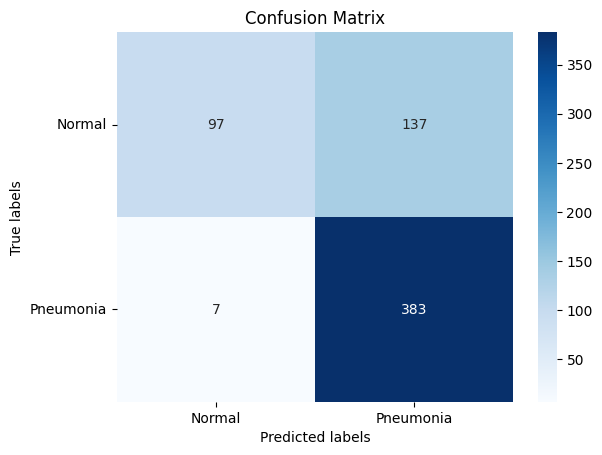

In [128]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [129]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.93      0.41      0.57       234
   PNEUMONIA       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.83      0.70      0.71       624
weighted avg       0.81      0.77      0.74       624



## Model 9: VGG16 Pretrained Model + 256 Neurons + 0.5 Dropout

In [130]:
# Model Architecture
model9 = Sequential()
model9.add(base_model2)
model9.add(Flatten())
model9.add(Dense(256, activation = 'relu'))
model9.add(Dropout(0.5)) # Adding a dropout of 0.5
model9.add(Dense(1, activation = 'sigmoid'))

In [131]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model9.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3)

In [132]:
# Compile the model
model9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [133]:
# Training the model
history9 = model9.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // batch_size,
    epochs=10,
    validation_data=val_generator3,
    validation_steps=val_generator3.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 3.3841 - accuracy: 0.9388
Epoch 1: val_loss improved from inf to 0.04052, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model9.hdf5
131/131 [==============================] - 76s 573ms/step - loss: 3.3841 - accuracy: 0.9388 - val_loss: 0.0405 - val_accuracy: 0.9863
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9801
Epoch 2: val_loss did not improve from 0.04052
131/131 [==============================] - 75s 576ms/step - loss: 0.0818 - accuracy: 0.9801 - val_loss: 0.1288 - val_accuracy: 0.9766
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9724
Epoch 3: val_loss did not improve from 0.04052
131/131 [==============================] - 69s 530ms/step - loss: 0.1150 - accuracy: 0.9724 - val_loss: 0.0700 - val_accuracy: 0.9834
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.0790 - accuracy:

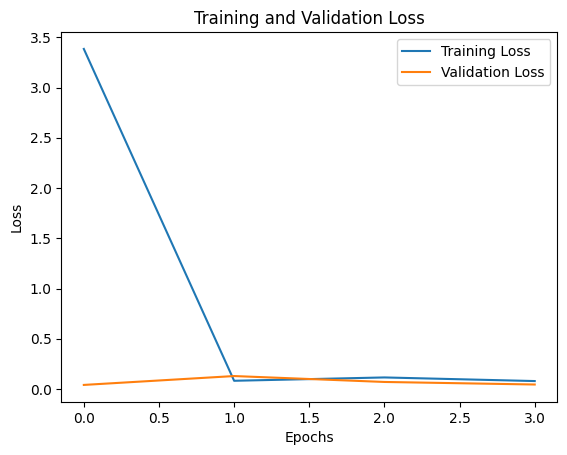

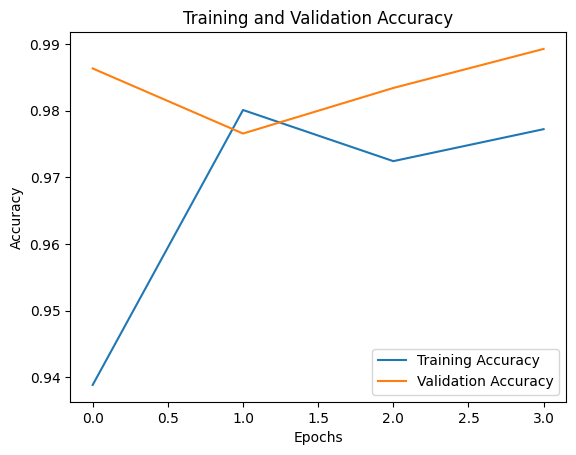

In [134]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history9.history['loss'], label='Training Loss')
plt.plot(history9.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history9.history['accuracy'], label='Training Accuracy')
plt.plot(history9.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [135]:
test_loss, test_acc = model9.evaluate(test_generator3, steps=test_generator3.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 8s 391ms/step - loss: 1.7478 - accuracy: 0.7862
Test loss: 1.7477959394454956
Test accuracy: 0.7861841917037964


### Making Predictions

In [136]:
predictions = model9.predict(test_generator3)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 8s 371ms/step


### Confusion Matrix

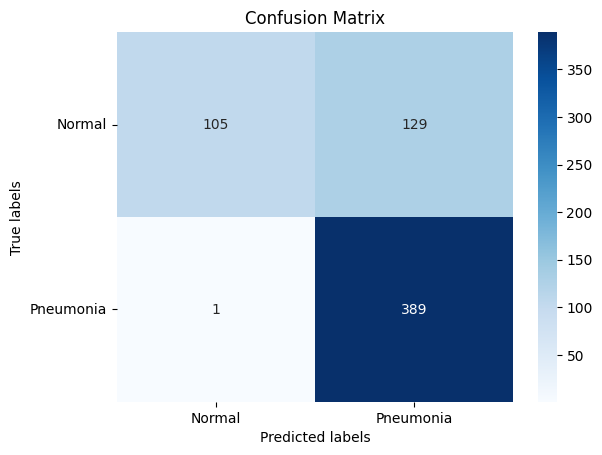

In [137]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator3.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [138]:
print(classification_report(y_true=test_generator3.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.99      0.45      0.62       234
   PNEUMONIA       0.75      1.00      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.74       624
weighted avg       0.84      0.79      0.77       624



## Model 10: 3 Convolution Blocks + 512 Neurons + 0.5 Dropout

In [139]:
# Building the CNN model with 3 convolution blocks
model10 = Sequential()
model10.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model10.add(MaxPooling2D(pool_size=(2,2)))
model10.add(Flatten())
model10.add(Dense(512, activation = 'relu'))
model10.add(Dropout(0.5)) # Adding a dropout of 0.5
model10.add(Dense(1, activation = 'sigmoid'))

In [140]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model10.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3)

In [141]:
# Compile the model
model10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [142]:
# Training the model
history10 = model10.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8144
Epoch 1: val_loss improved from inf to 0.22169, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model10.hdf5
131/131 [==============================] - 70s 518ms/step - loss: 0.4120 - accuracy: 0.8144 - val_loss: 0.2217 - val_accuracy: 0.9033
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.8995
Epoch 2: val_loss improved from 0.22169 to 0.17679, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model10.hdf5
131/131 [==============================] - 73s 557ms/step - loss: 0.2438 - accuracy: 0.8995 - val_loss: 0.1768 - val_accuracy: 0.9336
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.9185
Epoch 3: val_loss improved from 0.17679 to 0.15877, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model10.hdf5
131/131 [==============================] - 73s 56

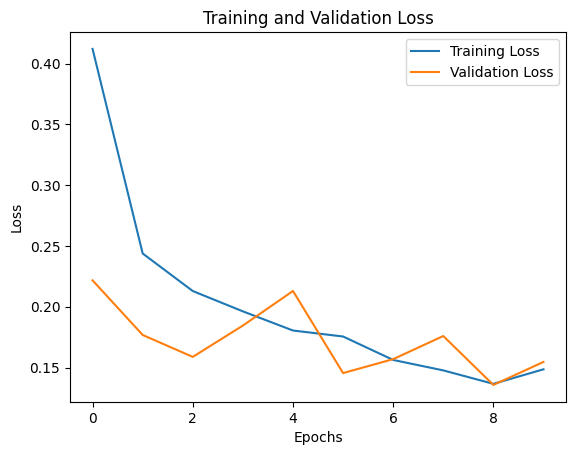

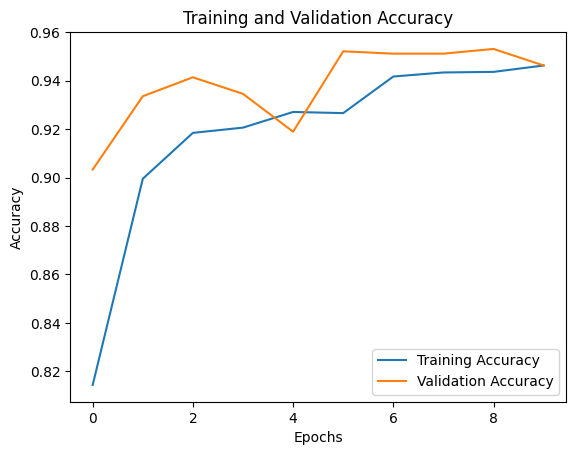

In [143]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history10.history['loss'], label='Training Loss')
plt.plot(history10.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history10.history['accuracy'], label='Training Accuracy')
plt.plot(history10.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [144]:
test_loss, test_acc = model10.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 5s 248ms/step - loss: 0.3991 - accuracy: 0.8783
Test loss: 0.39913344383239746
Test accuracy: 0.8782894611358643


In [145]:
predictions = model10.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 4s 181ms/step


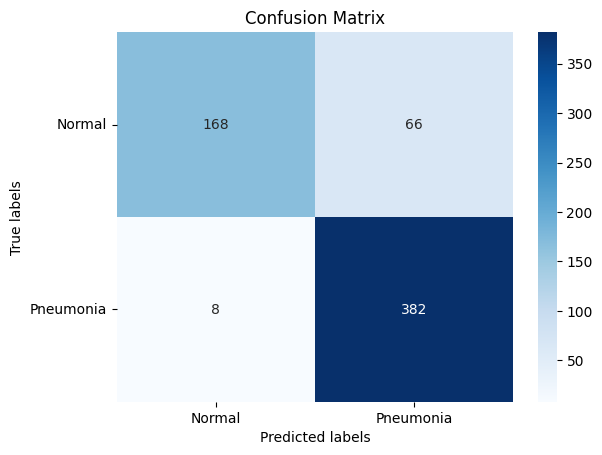

In [146]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

In [147]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.95      0.72      0.82       234
   PNEUMONIA       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.85      0.87       624
weighted avg       0.89      0.88      0.88       624



## Model 11: VGG16 Pretrained Model + 64 neurons + 0.5 Dropout

In [148]:
# Model Architecture
model11 = Sequential()
model11.add(base_model2)
model11.add(Flatten())
model11.add(Dense(64, activation = 'relu'))
model11.add(Dropout(0.5)) # Adding a dropout of 0.5
model11.add(Dense(1, activation = 'sigmoid'))

In [149]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model11.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3)

In [150]:
# Compile the model
model11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [151]:
# Training the model
history11 = model11.fit(
    train_generator3,
    steps_per_epoch=train_generator3.samples // batch_size,
    epochs=10,
    validation_data=val_generator3,
    validation_steps=val_generator3.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 1.1259 - accuracy: 0.8770
Epoch 1: val_loss improved from inf to 0.20573, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model11.hdf5
131/131 [==============================] - 72s 534ms/step - loss: 1.1259 - accuracy: 0.8770 - val_loss: 0.2057 - val_accuracy: 0.9424
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9381
Epoch 2: val_loss improved from 0.20573 to 0.10401, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model11.hdf5
131/131 [==============================] - 77s 588ms/step - loss: 0.1878 - accuracy: 0.9381 - val_loss: 0.1040 - val_accuracy: 0.9854
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.9568
Epoch 3: val_loss improved from 0.10401 to 0.07563, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model11.hdf5
131/131 [==============================] - 76s 57

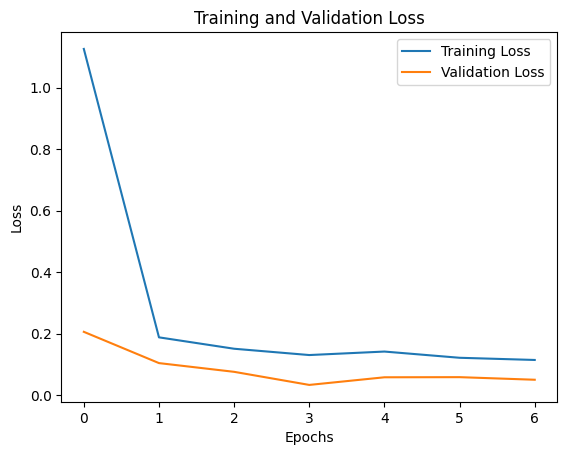

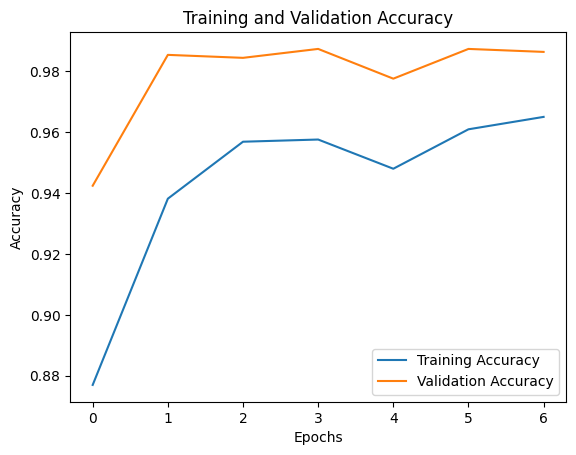

In [152]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history11.history['loss'], label='Training Loss')
plt.plot(history11.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history11.history['accuracy'], label='Training Accuracy')
plt.plot(history11.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [153]:
test_loss, test_acc = model11.evaluate(test_generator3, steps=test_generator3.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 8s 383ms/step - loss: 1.8287 - accuracy: 0.8289
Test loss: 1.8286895751953125
Test accuracy: 0.8289473652839661


In [154]:
predictions = model11.predict(test_generator3)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 8s 391ms/step


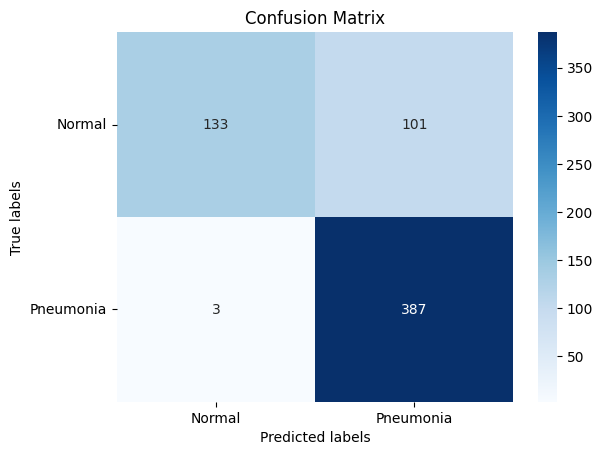

In [155]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator3.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

In [156]:
print(classification_report(y_true=test_generator3.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.57      0.72       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.89      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



## Model 12: Model 10 (3 Convolution Blocks + 512 Neurons + 0.5 Dropout) + 0.001 learning rate

In [157]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model12.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3)

In [159]:
# Compile the model
model10.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [160]:
# Training the model
history12 = model10.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9477
Epoch 1: val_loss improved from inf to 0.16342, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model12.hdf5
131/131 [==============================] - 70s 521ms/step - loss: 0.1407 - accuracy: 0.9477 - val_loss: 0.1634 - val_accuracy: 0.9365
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9434
Epoch 2: val_loss improved from 0.16342 to 0.12767, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model12.hdf5
131/131 [==============================] - 72s 553ms/step - loss: 0.1405 - accuracy: 0.9434 - val_loss: 0.1277 - val_accuracy: 0.9551
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9535
Epoch 3: val_loss did not improve from 0.12767
131/131 [==============================] - 67s 512ms/step - loss: 0.1228 - accuracy: 0.9535 - val_loss: 0.1685 - val_accuracy: 0.9463
E

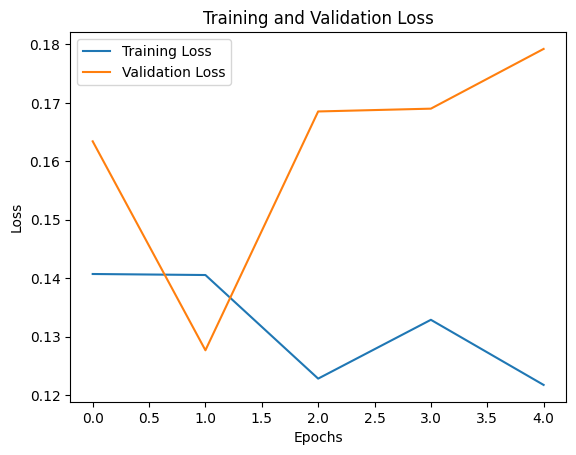

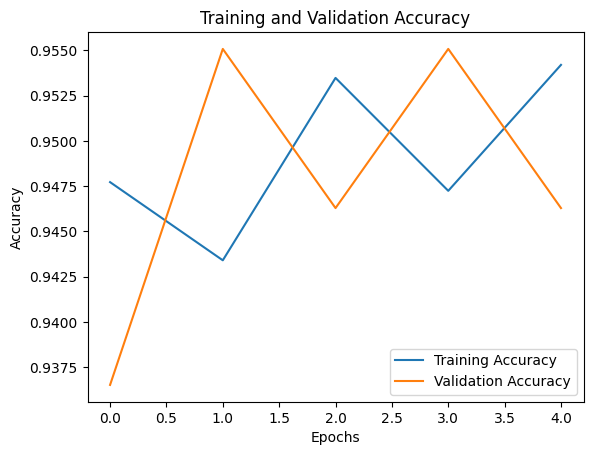

In [161]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history12.history['loss'], label='Training Loss')
plt.plot(history12.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history12.history['accuracy'], label='Training Accuracy')
plt.plot(history12.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [163]:
test_loss, test_acc = model10.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 4s 184ms/step - loss: 0.5761 - accuracy: 0.8026
Test loss: 0.5760908722877502
Test accuracy: 0.8026315569877625


In [164]:
predictions = model10.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 6s 253ms/step


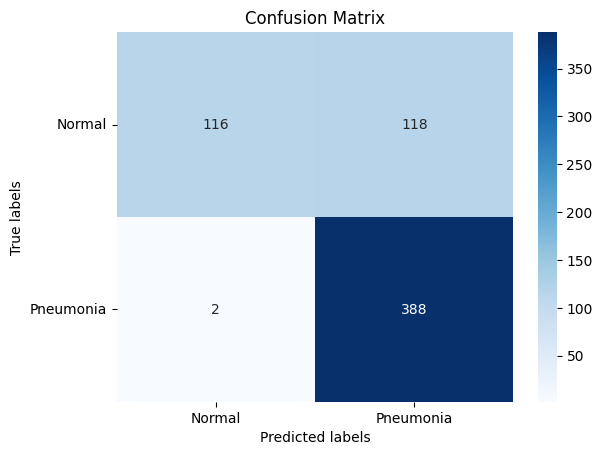

In [165]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

In [166]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.50      0.66       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.85      0.81      0.79       624



## Model 13: Pre-trained MobileNet Model + 0.25 Dropout + 512 Neurons

### Building the model architecture by adding classification layers

In [167]:
model13 = Sequential()
model13.add(base_model)
model13.add(Flatten())
model13.add(Dense(512, activation = 'relu'))
model13.add(Dropout(0.25)) # Adding a dropout of 0.25
model13.add(Dense(1, activation = 'sigmoid'))

### Defining Model Checkpoint and Early Stopping

In [169]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model13.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3)

### Compiling the model

In [170]:
model13.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the model

In [171]:
history13 = model13.fit(
    train_generator2,
    steps_per_epoch=train_generator2.samples // batch_size,
    epochs=10,
    validation_data=val_generator2,
    validation_steps=val_generator2.samples // batch_size,
)

Epoch 1/10
131/131 [==============================] - 147s 1s/step - loss: 2.7317 - accuracy: 0.9283 - val_loss: 0.0706 - val_accuracy: 0.9727
Epoch 2/10
131/131 [==============================] - 127s 973ms/step - loss: 0.0923 - accuracy: 0.9657 - val_loss: 0.0774 - val_accuracy: 0.9707
Epoch 3/10
131/131 [==============================] - 125s 949ms/step - loss: 0.0831 - accuracy: 0.9659 - val_loss: 0.0709 - val_accuracy: 0.9756
Epoch 4/10
131/131 [==============================] - 127s 970ms/step - loss: 0.0685 - accuracy: 0.9731 - val_loss: 0.0652 - val_accuracy: 0.9736
Epoch 5/10
131/131 [==============================] - 128s 974ms/step - loss: 0.0567 - accuracy: 0.9794 - val_loss: 0.0582 - val_accuracy: 0.9756
Epoch 6/10
131/131 [==============================] - 128s 975ms/step - loss: 0.0688 - accuracy: 0.9743 - val_loss: 0.0691 - val_accuracy: 0.9707
Epoch 7/10
131/131 [==============================] - 129s 984ms/step - loss: 0.0638 - accuracy: 0.9724 - val_loss: 0.0743 - va

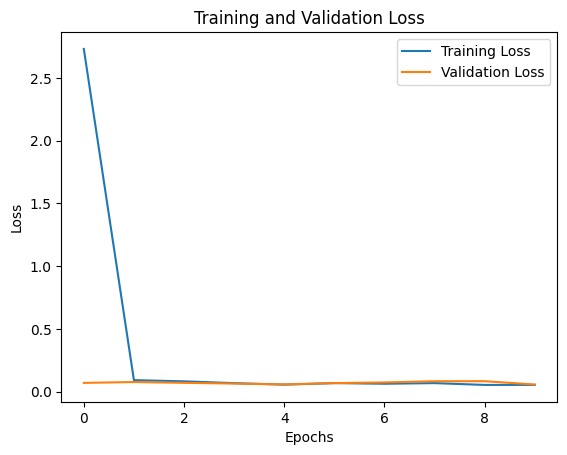

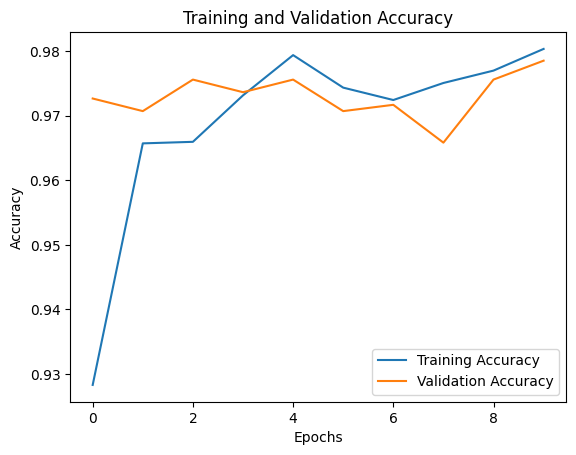

In [172]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history13.history['loss'], label='Training Loss')
plt.plot(history13.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()


# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history13.history['accuracy'], label='Training Accuracy')
plt.plot(history13.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

### Evaluating the model on the test set

In [173]:
test_loss, test_acc = model13.evaluate(test_generator2, steps=test_generator2.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 6s 297ms/step - loss: 0.4515 - accuracy: 0.8964
Test loss: 0.45154139399528503
Test accuracy: 0.8963815569877625


### Making Predictions

In [174]:
predictions = model13.predict(test_generator2)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 8s 343ms/step


### Confusion Matrix

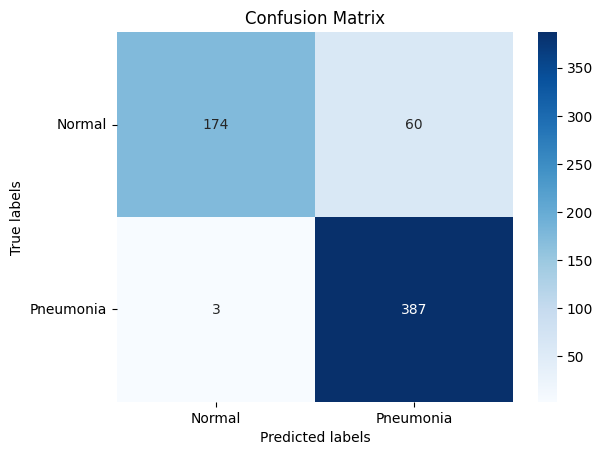

In [175]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator2.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [176]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.98      0.74      0.85       234
   PNEUMONIA       0.87      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



## Model 14: 4 Convolution Blocks + 512 Neurons + 0.25 Dropout

In [184]:
# Building the CNN model with 4 convolution blocks
model14 = Sequential()
model14.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(256,256,1), activation = 'relu', padding = 'same'))
model14.add(MaxPooling2D(pool_size=(2,2)))
model14.add(Conv2D(filters=64, kernel_size=(3,3), activation = 'relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))
model14.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))
model14.add(Conv2D(filters=128, kernel_size=(3,3), activation = 'relu'))
model14.add(MaxPooling2D(pool_size=(2,2)))
model14.add(Flatten())
model14.add(Dense(512, activation = 'relu'))
model14.add(Dropout(0.25)) # Adding a dropout of 0.25
model14.add(Dense(1, activation = 'sigmoid'))

In [185]:
model_filepath = "/content/drive/MyDrive/chest_xray/Models"
chkpt = ModelCheckpoint(os.path.join(model_filepath, "chest_xray_model14.hdf5"), save_best_only=True, verbose = 1)
es = EarlyStopping(patience = 3)

In [186]:
# Compile the model
model14.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [187]:
# Training the model
history14 = model14.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks = [chkpt, es]
)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.4301 - accuracy: 0.8065
Epoch 1: val_loss improved from inf to 0.24216, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model14.hdf5
131/131 [==============================] - 71s 513ms/step - loss: 0.4301 - accuracy: 0.8065 - val_loss: 0.2422 - val_accuracy: 0.9102
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.8914
Epoch 2: val_loss improved from 0.24216 to 0.22368, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model14.hdf5
131/131 [==============================] - 72s 551ms/step - loss: 0.2527 - accuracy: 0.8914 - val_loss: 0.2237 - val_accuracy: 0.9053
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9158
Epoch 3: val_loss improved from 0.22368 to 0.19498, saving model to /content/drive/MyDrive/chest_xray/Models/chest_xray_model14.hdf5
131/131 [==============================] - 67s 51

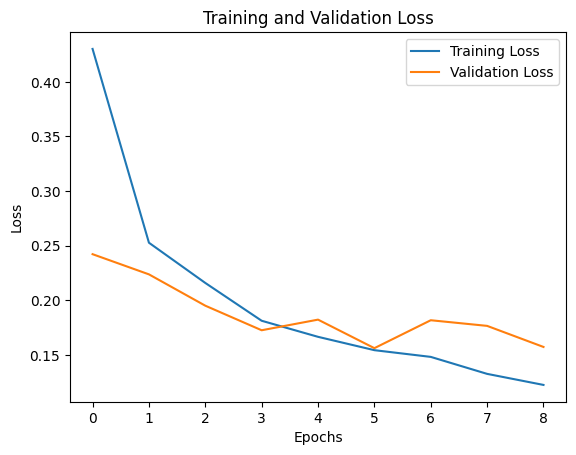

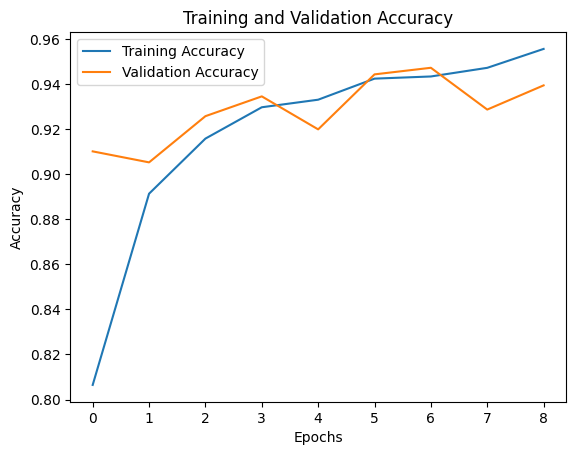

In [188]:
# Plotting the Training Loss versus the Validation Loss
plt.plot(history14.history['loss'], label='Training Loss')
plt.plot(history14.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = "best")
plt.show()

# Plotting the Training Accuracy versus the Validation Accuracy
plt.plot(history14.history['accuracy'], label='Training Accuracy')
plt.plot(history14.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = "best")
plt.show()

In [189]:
test_loss, test_acc = model14.evaluate(test_generator, steps=test_generator.samples // batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

19/19 [==============================] - 4s 188ms/step - loss: 0.2753 - accuracy: 0.9128
Test loss: 0.27529072761535645
Test accuracy: 0.9128289222717285


### Making Predictions

In [190]:
predictions = model14.predict(test_generator)
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

20/20 [==============================] - 4s 176ms/step


### Confusion Matrix

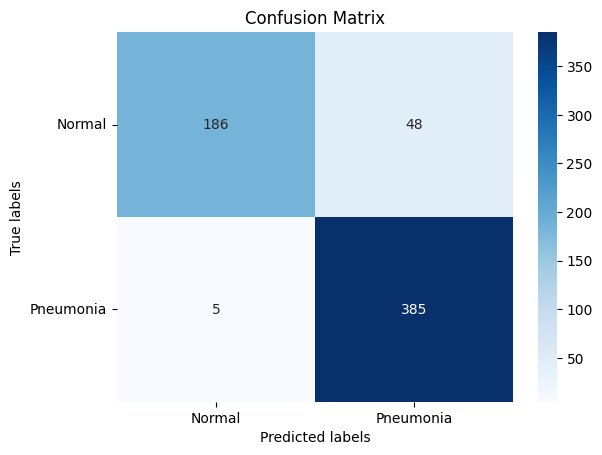

In [191]:
labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(test_generator.classes, predictions)

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

### Classification Report

In [192]:
print(classification_report(y_true=test_generator.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.97      0.79      0.88       234
   PNEUMONIA       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624

